<a href="https://colab.research.google.com/github/MohMaya/MGMT_Codes/blob/main/PortfolioMGMT645.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install pandas
!pip install yfinance
!pip install matplotlib
!pip install statsmodels
!pip install scipy
!pip install seaborn
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.6 MB/s eta 0:00:00


In [9]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt.plotting import plot_efficient_frontier
from pypfopt import objective_functions
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel


def black_litterman_plus_risk_analysis():

    def safe_convert(x):
        try:
            return float(x.strip('%')) / 100
        except ValueError:
            return np.nan  # Return NaN for non-numeric values


    # The Input Files
    spy_mom_returns_file = 'spy_hist_returns.csv'
    etf_mom_returns_file = 'etf_hist_returns.csv'
    spy_curr_weights_file = 'spy_curr_weights.csv'

    ####################################################
    # Tickers, starting data date, ending data date    #
    # for estimation of covariance matrix              #
    ####################################################

    ticker_dict = {
        'XLE': 'Energy',
        'XLB': 'Materials',
        'XLI': 'Industrials',
        'XLY': 'Consumer Discretionary',
        'XLP': 'Consumer Staples',
        'XLV': 'Health Care',
        'XLF': 'Financials',
        'XLK': 'Information Technology',
        'XLC': 'Communication Services',
        'XLU': 'Utilities',
        'XLRE': 'Real Estate',
    }

    tickers = list(ticker_dict.keys())
    benchmark_ticker = 'SPY'
    start_date = '2020-1-1'
    end_date = '2024-9-30'
    freq = '1mo'# Calculating on monthly returns

    if freq == '1d':
        divisor = 252
    elif freq == '1wk':
        divisor = 52
    elif freq == '1mo':
        divisor = 12

    # Getting the risk-free rate
    risk_free_rate = 0
    while True:
        try:
            risk_free_rate = float(input("Enter the risk-free rate (Rf) in decimals (e.g. 0.05 for 5%): "))
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    # Getting the market return
    market_return = 0
    while True:
        try:
            market_return = float(input("Enter the market return (Rm) in decimals (e.g. 0.05 for 5%): "))
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    market_risk_premium = market_return - risk_free_rate

    ####################################################
    # Set to 1 if you want the code to estimate the    #
    # covariance matrix.  method = 0 to use sample     #
    # covariance matrix and method = 1 to use          #
    # exponential weighting                            #
    ####################################################

    estimate_covariance = 0
    method = 0
    while True:
        try:
            estimate_covariance = int(input("Enter 1 to estimate the covariance matrix from yahoo finance, 0 to use the covariance matrix from the shared data (For default, enter 0): "))
            if estimate_covariance not in [0, 1]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter 0 or 1.")
    while True:
        try:
            method = int(input("Enter 1 to use exponential weighting, 0 to use the sample covariance matrix (For default, enter 0): "))
            if method not in [0, 1]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter 0 or 1.")

    ####################################################
    # allow_short = 0 prohibits short sales.           #
    # allow_short = 1 enables short selling            #
    ####################################################

    allow_short = 1
    while True:
        try:
            allow_short = int(input("Enter 1 to allow short selling, 0 to prohibit short selling (For default, enter 1): "))
            if allow_short not in [0, 1]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter 0 or 1.")

    ####################################################
    # Allowable objective functions are                #
    # 'target_return' to find min vol for E[R]         #
    # 'target_volatility' to find max E[R] for vol     #
    # 'max_sharpe' to maximize Sharpe ratio            #
    ####################################################

    objective_function = 'target_return'
    while True:
        try:
            objective_function_input = input("Enter \n0 : 'target_return' => Find min volatility for expected return, \n1 : 'target_volatility' => Find max expected return for volatility, \n2 : 'max_sharpe' => Maximize Sharpe ratio \n: ")
            if objective_function_input not in ['0', '1', '2']:
                raise ValueError
            if objective_function_input == '0':
                objective_function = 'target_return'
            elif objective_function_input == '1':
                objective_function = 'target_volatility'
            elif objective_function_input == '2':
                objective_function = 'max_sharpe'
            break
        except ValueError:
            print("Invalid input. Please enter 0, 1, or 2.")

    ####################################################
    # By default, the target return or volatility will #
    # be determined by the weights that you input to   #
    # to the code.                                     #
    ####################################################


    confidences=[]#[0.25]*len(tickers)
    weights=[]#[round(1/len(tickers), 4)]*len(tickers)
    forecast_returns=[]#[0.08]*len(tickers)

    while True:
        for ticker in ticker_dict.keys():
            print(f"For {ticker_dict[ticker]} ({ticker}), Please Enter:")

            temp_forecast_return = 0.0
            while True:
                try:
                    temp_forecast_return = round(float(input(f"\tForecast return [In decimals (e.g. 0.05 for 5%)]: ")), 4)
                    break
                except ValueError:
                    print("Invalid input. Please enter a number.")


            temp_confidence = 0.0
            while True:
                try:
                    temp_confidence = round(float(input(f"\tConfidence [Between 0.0 and 1.0]: ")), 4)
                    if temp_confidence < 0.0 or temp_confidence > 1.0:
                        raise ValueError
                    break
                except ValueError:
                    print("Invalid input. Please enter a number between 0.0 and 1.0.")

            temp_weight = 0.0
            while True:
                try:
                    temp_weight = round(float(input(f"Weight [Between 0.0 and 1.0, and the sum of all weights must equal 1.0] [Current Sum: {round(sum(weights), 4)}]: ")), 4)
                    if temp_weight < 0.0 or temp_weight > 1.0:
                        raise ValueError
                    break
                except ValueError:
                    print("Invalid input. Please enter a number between 0.0 and 1.0.")



            confidences.append(temp_confidence)
            weights.append(temp_weight)
            forecast_returns.append(temp_forecast_return)

        if round(sum(weights), 4) != 1.0:
            print("The sum of all weights must equal 1.0. Current sum: ", round(sum(weights), 4))
            confidences = []
            weights = []
            forecast_returns = []
        else:
            break

    print("*"*50)
    print("Proceeding with the following Information:")
    for i in range(len(ticker_dict)):
        print(f"{ticker_dict[list(ticker_dict.keys())[i]]} ({list(ticker_dict.keys())[i]}): Confidence = {confidences[i]}, Weight = {weights[i]}, Forecast Return = {forecast_returns[i]}")
    print("*"*50)

    ####################################################
    # n_constraints is the number of constraints you   #
    # want to impose on the optimization.  Must be     #
    # specified as equality or inequality constrants.  #
    ####################################################

    n_constraints = 0
    ## Setting n_constraints to 0 means no constraints. Setting it to 0 here since we are not imposing any constraints. You can change this to 1 or more if you want to impose constraints.

    ####################################################
    # The example constraint here is for the           #
    # equity weights to sum to 0.80                    #
    ####################################################
    constraint=[]
    constraint.append('x[3]+x[4]+x[5] == 0.80')
    constraint.append('x[0] >= 0.05')
    constraint.append('x[1] >= 0.05')
    constraint.append('x[2] >= 0.05')


    if estimate_covariance == 1:
        prices_df = yf.download(tickers,start=start_date, end=end_date,interval=freq)
        returns_df = prices_df['Adj Close'].pct_change().dropna()
        if method == 0:
            if freq == '1d':
                Sigma = risk_models.sample_cov(returns_df,returns_data = True, frequency = 252)
            elif freq == '1mo':
                Sigma = risk_models.sample_cov(returns_df,returns_data = True, frequency = 12)
            elif freq == '1wk':
                Sigma = risk_models.sample_cov(returns_df,returns_data = True, frequency = 52)
        elif method == 1:
            if freq == '1d':
                Sigma = risk_models.exp_cov(returns_df,returns_data = True, frequency = 252)
            elif freq == '1mo':
                Sigma = risk_models.exp_cov(returns_df,returns_data = True, frequency = 12)
            elif freq == '1wk':
                Sigma = risk_models.exp_cov(returns_df,returns_data = True, frequency = 52)
    elif estimate_covariance == 0:
        # Importing the data
        etf_returns = pd.read_csv(etf_mom_returns_file)

        # Transpose the DataFrame so that tickers become columns
        etf_returns = etf_returns.T

        # Convert percentage strings to float values, replacing non-numeric values with NaN
        etf_returns = etf_returns.map(safe_convert)

        # Remove any rows or columns that are entirely NaN
        etf_returns = etf_returns.dropna(how='all', axis=1).dropna(how='all', axis=0)

        # For remaining NaN values, you might want to fill them with a specific value or strategy
        # For example, filling with 0 or the mean of the column
        etf_returns = etf_returns.fillna(etf_returns.mean())

        # Rename the columns to use the tickers
        etf_returns.columns = tickers

        # Now calculate the covariance matrix
        Sigma = etf_returns.cov()


    # Calculate mu
    mu_data = {tickers[i]: forecast_returns[i] for i in range(len(tickers))}


    # Convert mu to a pandas DataFrame
    mu = pd.DataFrame(list(mu_data.items()), columns=['TICKER', 'E[R]'])
    mu.set_index('TICKER', inplace=True)

    # Calculate mu
    w_data = {tickers[i]: weights[i] for i in range(len(tickers))}


    # Convert views to a pandas DataFrame
    w = pd.DataFrame(list(w_data.items()), columns=['TICKER', 'WEIGHT'])
    w.set_index('TICKER', inplace=True)

    market_weights = pd.read_csv(spy_curr_weights_file)

    # Ensure market_weights index is the TICKER column
    market_weights.set_index('TICKER', inplace=True)
    # Calculate delta using the market weights directly
    market_weight_vector = market_weights['WEIGHT']
    delta = market_risk_premium / (market_weight_vector @ Sigma @ market_weight_vector)

    # For the rest of the calculations, we'll use the original weights
    # Make sure the weights are aligned with the Sigma matrix
    aligned_weights = pd.Series(index=Sigma.index, data=weights)

    # Convert aligned_weights Series to DataFrame
    aligned_weights_df = aligned_weights.reset_index()
    aligned_weights_df.columns = ['TICKER', 'WEIGHT']
    aligned_weights_df.set_index('TICKER', inplace=True)


    mcaps = {}
    for ticker in tickers:
        if ticker in aligned_weights_df.index:
            mcaps[ticker] = aligned_weights_df.loc[ticker, 'WEIGHT']
        else:
            print(f"Warning: {ticker} not found in aligned_weights_df")


    views = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        if ticker in mu.index:
            views[ticker] = mu.loc[ticker, 'E[R]']
        else:
            print(f"Warning: Ticker {ticker} not found in mu DataFrame. Using default value.")
            views[ticker] = forecast_returns[i]  # Use the forecast return as a fallback


    market_prior = black_litterman.market_implied_prior_returns(market_caps=mcaps, risk_aversion=delta, cov_matrix=Sigma, risk_free_rate=risk_free_rate)
    bl = BlackLittermanModel(cov_matrix=Sigma, pi=market_prior, absolute_views=views, omega="idzorek", view_confidences=confidences, risk_free_rate=risk_free_rate)
    ret_bl = bl.bl_returns()

    rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(views)],
                index=["Prior", "Posterior", "Views"]).T

    rets_df.plot.bar(figsize=(12,8))
    plt.savefig("PriorPosteriorView.png")
    plt.show()

    # Convert w and mu to numpy arrays
    w_np = w.to_numpy().flatten()  # Flatten to ensure it's a 1D array
    mu_np = mu.to_numpy().flatten()

    # Perform the dot product
    target = np.dot(w_np, mu_np)

    # For the next line, also convert Sigma to a numpy array
    Sigma_np = Sigma.to_numpy()
    sigma = np.sqrt(w_np @ Sigma_np @ w_np)

    if allow_short == 0:
        ef = EfficientFrontier(ret_bl, Sigma)
        ef_hat = EfficientFrontier(ret_bl, Sigma)
        range_plot = np.linspace(np.min(mu),np.max(mu))

    elif allow_short == 1:
        ef = EfficientFrontier(ret_bl, Sigma, weight_bounds=(-1, 1))
        ef_hat = EfficientFrontier(ret_bl, Sigma, weight_bounds=(-1, 1))
        range_plot = np.linspace(np.min(mu)-0.005,np.max(mu)+0.005)

    if n_constraints > 0:
        for i in range (0, n_constraints):
            ef.add_constraint(lambda x: eval(constraint[i]))
            ef_hat.add_constraint(lambda x: eval(constraint[i]))

    if objective_function == 'MaxSharpe':
        wt = ef.max_sharpe(risk_free_rate=risk_free_rate)
    elif objective_function == 'target_return':
        wt = ef.efficient_return(target)
    elif objective_function == 'target_volatility':
        wt = ef.efficient_risk(target)

    clean_weights = ef.clean_weights()

    print('Efficient Weights', clean_weights)
    print('')
    print('Efficient Portfolio Performance')
    ret_target_frontier, std_target_frontier, _ = ef.portfolio_performance(clean_weights, risk_free_rate = risk_free_rate)
    print('')
    print('Portfolio Performance')
    print('Expected annual return: {:.1%}'.format(target))
    print('Annual volatility: {:.1%}'.format(sigma))
    print('Sharpe Ratio: {:.2f}'.format((target-risk_free_rate)/sigma))

    fig, ax = plt.subplots()

    ax.scatter(std_target_frontier, ret_target_frontier, marker="*", s=200, c="r", label="CAPM Target Portfolio")
    ax.scatter(sigma, target, marker='*', s=200, c="g", label="Test Portfolio")

    plt.style.use('classic')
    plot_efficient_frontier(ef_hat, ax = ax, show_assets=False, show_tickers=False, ef_param_range=range_plot)               # Plot the efficient frontier

    plt.savefig("ef_subjective.png")
    plt.show()


    custom_benchmark = 0
    # Load the CSV file
    spy_weights_df = pd.read_csv(spy_curr_weights_file)

    # Extract the weights and convert to a numpy array
    benchmark_weights = spy_weights_df['WEIGHT'].to_numpy()
    factor_tickers = ['BIL','MTUM','QUAL','SIZE','VLUE','USMV','IQLT','IMTM','IVLU']

    ####################################################
    # Inputs for Monte Carlo VaR.  Initial portfolio   #
    # value, number of periods to simulate per sample, #
    # number of total samples, and random seed.        #
    ####################################################

    V0 = 10000000
    duration = 30
    number_of_samples=10000
    seed = 42
    monte_carlo_file = 'MonteCarlo.jpg'


    prices_df = yf.download(tickers, start=start_date, end=end_date, interval=freq)
    returns_df = prices_df['Adj Close'].pct_change().dropna()
    returns_df.index = pd.to_datetime(returns_df.index)

    prices_rf = yf.download(factor_tickers, start=start_date, end=end_date, interval=freq)
    returns_rf = prices_rf['Adj Close'].pct_change().dropna()

    returns = returns_df.copy()
    returns['Portfolio'] = returns_df.dot(w_np)

    if custom_benchmark == 0:
        tickerlist = [benchmark_ticker, 'BIL']
        prices_benchmark = yf.download(tickerlist, start=start_date, end=end_date, interval=freq)
        returns_benchmark = prices_benchmark['Adj Close'].pct_change().dropna()
        returns['Benchmark'] = returns_benchmark[benchmark_ticker]
    elif custom_benchmark == 1:
        returns['Benchmark'] = returns_rf.dot(benchmark_weights)

    returns['Rf'] = returns_rf['BIL']

    factors = factor_tickers[2:len(factor_tickers)+1]
    for i in factors:
        returns[i] = returns_rf[i]

    returns['RpRf'] = returns['Portfolio'] - returns['Rf']
    returns['RbRf'] = returns['Benchmark'] - returns['Rf']

    model = smf.ols(formula='RpRf ~ RbRf', data=returns)
    results = model.fit()

    print(results.summary())

    e_p = results.resid
    residuals = pd.DataFrame({'Portfolio': e_p})

    active_risk = np.var(returns['RpRf']-returns['RbRf'])

    for i in factors:
        y=returns[i]-returns['Rf']
        y = np.array(y)
        X = returns['RbRf']
        X = np.array(X).reshape(-1,1)
        market_model = sm.OLS(y, X)
        market_results= market_model.fit()
        residuals[i] = market_results.resid

    formula_string = 'Portfolio ~ '+factors[0]
    for i in range(1,len(factors)):
        formula_string = formula_string+' + '+factors[i]


    factor_model = smf.ols(formula=formula_string,data=residuals)
    factor_results = factor_model.fit()
    print(factor_results.summary())

    u_p = factor_results.resid

    active_risk = np.var(returns['RpRf']-returns['RbRf'])
    print('**************')
    print('**************')
    print('Active Risk:  {:.2%}'.format(np.sqrt(divisor*active_risk)))
    print('Decomposition')
    print('Market Timing:  {:.2%}'.format(((results.params['RbRf']-1)**2)*np.var(returns['RbRf'])/active_risk))
    print('Selection:  {:.2%}'.format(np.var(e_p)/active_risk))
    print('**************')
    print('**************')
    selection = np.var(e_p)
    print('Decomposition')
    print('Common Factor:  {:.2%}'.format(np.var(u_p)/selection))
    print('Asset Selection:  {:.2%}'.format(1-np.var(u_p)/selection))
    print('**************')
    print('**************')

    print('Historical Performance Statistics')
    print('Alpha: {:.2%}'.format(results.params['Intercept']*divisor))
    print('Geometric Mean of Portfolio Return: {:.2%}'.format(np.prod(1+returns['Portfolio'])**(1/np.round(len(returns)/divisor))-1))
    print('Geometric Mean of Benchmark: {:.2%}'.format(np.prod(1+returns['Benchmark'])**(1/np.round(len(returns)/divisor))-1))
    print('Standard Deviation: {:.2%}'.format(np.sqrt(divisor)*np.std(returns['Portfolio'])))

    returns['1+Rp']=returns['Portfolio']+1
    returns['Portfolio Value']=returns['1+Rp'].cumprod()
    returns['Rolling Maximum'] = returns['Portfolio Value'].rolling(min_periods=1, window=divisor).max()
    returns['Daily Drawdown'] = returns['Portfolio Value']/returns['Rolling Maximum'] - 1.0
    returns['Max. Daily Drawdown'] = returns['Daily Drawdown'].rolling(min_periods=1, window=divisor).min()

    print('**************')
    print('**************')
    print('Maximum Drawdown: {:.2%}'.format(returns['Max. Daily Drawdown'].min()))
    returns.plot(y=['Daily Drawdown','Max. Daily Drawdown'])
    plt.show()

    mu = np.log(1+target-0.5*sigma**2)/divisor
    sig = sigma/np.sqrt(divisor)

    loss1 = []
    np.random.seed(seed)
    for i in range (0, number_of_samples):
        r1=st.norm.rvs(loc=mu, scale=sig, size=duration)
        V1 = V0*np.prod(np.exp(r1))
        loss1.append(V1-V0)

    fig, ax = plt.subplots()

    ax.hist(loss1,bins=100, density=True, alpha=0.4)
    np1_10th = np.percentile(loss1,10)
    np1_5th = np.percentile(loss1,5)
    np1_1st = np.percentile(loss1,1)
    ax.axvline(x=np1_5th, color='r', linestyle='--', label='5th Percentile')
    print('10% VaR for ${:,.0f}  Portfolio = ${:,.0f}'.format(V0, np.abs(np1_10th)))
    print('5% VaR for ${:,.0f} Portfolio = ${:,.0f}'.format(V0, np.abs(np1_5th)))
    print('1% VaR for ${:,.0f} Portfolio = ${:,.0f}'.format(V0, np.abs(np1_1st)))
    print('')
    ax.set_title('Distribution of Monthly Gains and Losses')



    plt.savefig(monte_carlo_file)
    plt.show()


Enter the risk-free rate (Rf) in decimals (e.g. 0.05 for 5%): 0.034
Enter the market return (Rm) in decimals (e.g. 0.05 for 5%): 0.08
Enter 1 to estimate the covariance matrix from yahoo finance, 0 to use the covariance matrix from the shared data (For default, enter 0): 0
Enter 1 to use exponential weighting, 0 to use the sample covariance matrix (For default, enter 0): 0
Enter 1 to allow short selling, 0 to prohibit short selling (For default, enter 1): 1
Enter 
0 : 'target_return' => Find min volatility for expected return, 
1 : 'target_volatility' => Find max expected return for volatility, 
2 : 'max_sharpe' => Maximize Sharpe ratio 
: 0
**************************************************
Proceeding with the following Information:
Energy (XLE): Confidence = 0.25, Weight = 0.0909, Forecast Return = 0.08
Materials (XLB): Confidence = 0.25, Weight = 0.0909, Forecast Return = 0.08
Industrials (XLI): Confidence = 0.25, Weight = 0.0909, Forecast Return = 0.08
Consumer Discretionary (XLY):

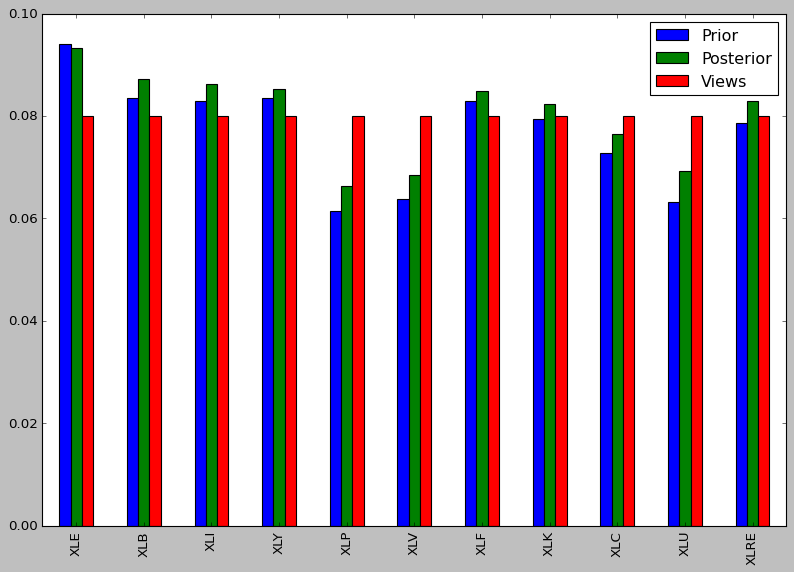

Efficient Weights OrderedDict([('XLE', 0.0752), ('XLB', 0.15266), ('XLI', 0.16519), ('XLY', -0.01968), ('XLP', 0.04238), ('XLV', 0.11833), ('XLF', -0.02434), ('XLK', 0.1176), ('XLC', 0.10389), ('XLU', 0.12133), ('XLRE', 0.14743)])

Efficient Portfolio Performance
Expected annual return: 8.0%
Annual volatility: 5.1%
Sharpe Ratio: 0.89

Portfolio Performance
Expected annual return: 8.0%
Annual volatility: 5.2%
Sharpe Ratio: 0.88


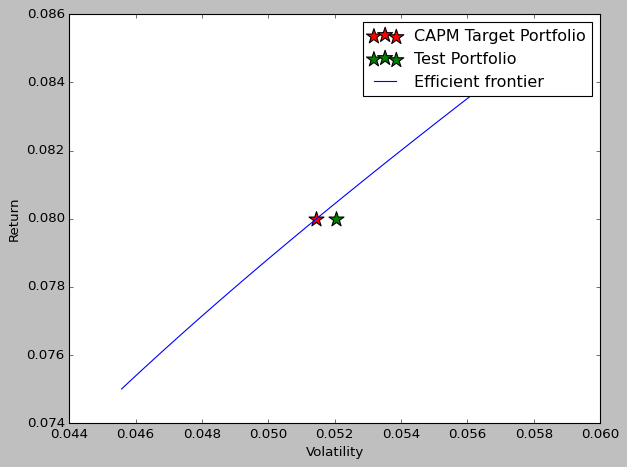

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  2 of 2 completed


                            OLS Regression Results                            
Dep. Variable:                   RpRf   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1054.
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           4.13e-37
Time:                        15:21:30   Log-Likelihood:                 168.67
No. Observations:                  56   AIC:                            -333.3
Df Residuals:                      54   BIC:                            -329.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.002     -0.610      0.5

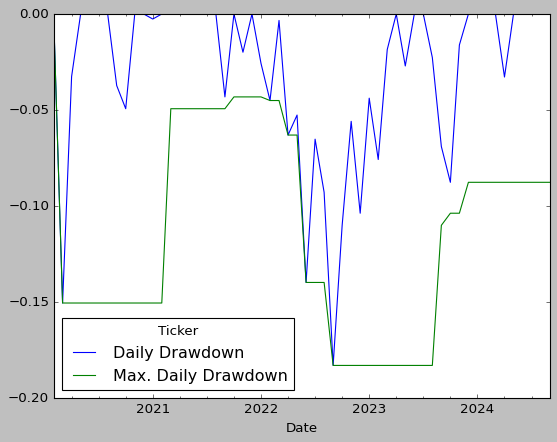

10% VaR for $10,000,000  Portfolio = $855,611
5% VaR for $10,000,000 Portfolio = $523,339
1% VaR for $10,000,000 Portfolio = $61,582



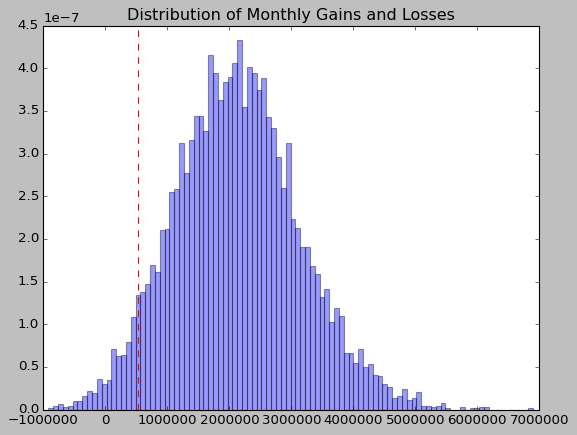

In [10]:
black_litterman_plus_risk_analysis()